<a href="https://colab.research.google.com/github/ameyaa/makemore_mlp/blob/main/makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [4]:
# vocabulary of chars in dataset and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
SZ = len(stoi)
itos = {i:c for c, i in stoi.items()}
print(itos)
print('SZ: ', SZ)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
SZ:  27


In [5]:
# build the dataset
block_sz = 3
X, Y = [], []
for w in words[:5]:
  #print(w)
  context = [0] * block_sz
  for c in w + '.':
    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '----->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
# embeddings - embed 27 possible chars into 2-dimensional space
C = torch.randn((SZ, 2))  # aka lookup table
C

tensor([[-0.7093, -1.5284],
        [ 0.6025,  0.4125],
        [-0.6243, -1.9668],
        [-1.7884, -0.2589],
        [ 1.1732,  2.2910],
        [-0.0618, -0.0953],
        [-0.3574, -0.3441],
        [-0.1733,  0.5318],
        [ 0.2233,  0.9138],
        [-2.3328, -0.1922],
        [ 1.3006, -0.3693],
        [-0.4751, -0.9409],
        [ 2.8055, -0.6441],
        [ 0.9960,  0.8637],
        [ 1.1519,  0.5445],
        [ 0.4819, -1.2415],
        [ 0.2776, -0.9697],
        [-1.5124,  0.2444],
        [ 0.2458, -1.1472],
        [-0.5072,  0.3090],
        [ 1.0662,  0.6764],
        [-1.5368, -1.1341],
        [ 0.1960, -0.9737],
        [ 1.2494, -0.3367],
        [-0.2439, -0.3553],
        [ 0.2264, -0.3832],
        [ 0.2204,  0.6706]])

In [8]:
# Example - how to embed an integer 5 into 27 x 2 dimensional tensor
print(C[5])  # method 1 - simpler/faster/preferred
# method 2 - dot product
oh = F.one_hot(torch.tensor(5), num_classes=SZ).float()
print(oh)
oh @ C

tensor([-0.0618, -0.0953])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


tensor([-0.0618, -0.0953])

In [9]:
# how to embed X in C --> just do C[X]
print('C shape: ', C.shape)
print('X shape: ', X.shape)
print('C[X] shape: ', C[X].shape)
print(X[13])
print(X[13,2])
print(C[X][13])
print(C[X][13,2])

C shape:  torch.Size([27, 2])
X shape:  torch.Size([32, 3])
C[X] shape:  torch.Size([32, 3, 2])
tensor([0, 0, 1])
tensor(1)
tensor([[-0.7093, -1.5284],
        [-0.7093, -1.5284],
        [ 0.6025,  0.4125]])
tensor([0.6025, 0.4125])


In [10]:
# embed input X into C
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
# layer 2 - hidden activation layer
# inputs to hidden layer: 3 x 2 = 6 (2-dimensional embedding and 3 of them)
num_neurons = 100
W1 = torch.randn((6, num_neurons))
b1 = torch.randn(num_neurons)

In [12]:
# The following is what we want to do
emb @ W1 + b1
# But it will error out since  emb (32 x 3 x 2) and W1 (6 x 100) are not compatible

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [13]:
# To fix the above error, we need to concatenate the (3 x 2 = 6 ) entries --> 32 x 3 x 2 --> 32 x 6
print(emb[:, 0, :].shape)
torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape
# Above code assumes block_size of 3 (0, 1, 2), so won't work if we change block_size

torch.Size([32, 2])


torch.Size([32, 6])

In [14]:
# Use unbind to fix above issue
# The following code is independent of block_size
ub = torch.unbind(emb, 1)
print(len(ub))
for i in range(len(ub)):
  print(ub[i].shape)
torch.cat(ub, 1).shape

3
torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])


torch.Size([32, 6])

In [15]:
# Alternative to unbind
a = torch.arange(6)
print(a)
print(a.view(3, 2))
print(a.view(2, 3))
# View doesn't reallocate new memory, but merely changes how the tensor is 'viewed'
print(emb.shape)
emb.view(32, 6).shape

tensor([0, 1, 2, 3, 4, 5])
tensor([[0, 1],
        [2, 3],
        [4, 5]])
tensor([[0, 1, 2],
        [3, 4, 5]])
torch.Size([32, 3, 2])


torch.Size([32, 6])

In [16]:
# Using .view instead of unbind
h = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2]) @ W1 + b1
print(h.shape)
h

torch.Size([32, 100])


tensor([[ 2.3300, -3.6589, -0.8923,  ...,  0.9275, -0.7548,  6.8407],
        [ 0.8042, -3.0765, -2.2856,  ...,  0.1210, -1.1471,  4.1269],
        [-0.9322,  0.2964, -2.4739,  ..., -2.1222, -0.5234, -0.7728],
        ...,
        [ 0.6332,  0.7084, -1.1054,  ..., -0.1273,  1.1170,  1.1981],
        [ 5.1610,  4.7561, -0.2561,  ...,  0.1406,  1.8599,  0.3654],
        [ 3.0950,  1.1185,  1.0605,  ..., -0.3582, -2.8355, -1.7521]])

In [17]:
# Slight variation in using .view (compared to above cell)
h = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1  # with -1, torch infers that dimension (in this case, 32)
print(h.shape)

torch.Size([32, 100])


In [18]:
# Double check if broadcasting is working correctly in the matrix multiplication/addition
p = emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1
print(p.shape)
print(b1.shape)
# 32 x 100
# 100
#      100  broadcasting will align 100 to right
# 1  x 100  create fake dimension 1 on left to get a row vector
# Do row-wise addition. So the same bias-vector will be added element-wise to the rows.
# This is what we want

torch.Size([32, 100])
torch.Size([100])


In [19]:
# Now apply tanh activation. Each element will be between [-1, 1] inclusive
h = torch.tanh(p + b1)
print(h.shape)
h

torch.Size([32, 100])


tensor([[ 0.9812, -0.9987, -0.7125,  ...,  0.7294, -0.6380,  1.0000],
        [ 0.6664, -0.9958, -0.9795,  ...,  0.1204, -0.8168,  0.9995],
        [-0.7316,  0.2880, -0.9859,  ..., -0.9717, -0.4803, -0.6486],
        ...,
        [ 0.5603,  0.6096, -0.8024,  ..., -0.1266,  0.8065,  0.8331],
        [ 0.9999,  0.9999, -0.2507,  ...,  0.1397,  0.9527,  0.3500],
        [ 0.9959,  0.8070,  0.7858,  ..., -0.3436, -0.9931, -0.9416]])

In [20]:
# layer 3 - softmax layer
print(h.shape[1])
print(SZ)
W2 = torch.randn(h.shape[1], SZ)
b2 = torch.randn(SZ)
print(W2.shape, b2.shape)

100
27
torch.Size([100, 27]) torch.Size([27])


In [21]:
# Calculate logits
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
# exponentiate to get fake counts
counts = logits.exp()
counts.shape

torch.Size([32, 27])

In [23]:
# compute probabilities
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [24]:
# print the actual Y values
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [25]:
# infer the predicted Y values from the probabilites
print(torch.arange(prob.shape[0]))
Y_pred = prob[torch.arange(prob.shape[0]), Y]
print(Y_pred)  # the probability for the index corresponding to actual Y values
# we haven't trained the model yet, ideal values for the probability would be 1

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
tensor([3.7099e-06, 1.8260e-12, 6.9399e-08, 1.3142e-07, 1.5175e-07, 3.1891e-04,
        2.0369e-14, 1.1837e-11, 2.2383e-02, 6.1461e-15, 2.1298e-10, 6.3829e-06,
        3.9745e-05, 2.3902e-09, 1.6939e-09, 2.6457e-01, 4.6574e-13, 7.6448e-08,
        3.1315e-04, 2.5768e-02, 4.9483e-05, 2.6173e-11, 3.6335e-18, 7.0119e-10,
        9.1453e-03, 6.7700e-04, 5.6020e-10, 3.1781e-06, 5.1982e-13, 8.1723e-16,
        3.8148e-07, 1.9201e-11])


In [26]:
# calculate the loss - remember, loss is to be minimized
loss = -Y_pred.log().mean()
print(loss)
# an alternate way to calculate loss
# cross entropy is a much better way:
# 1. efficient in terms of compute & memory
# 2. for large positive values, exp() results in nan
#    cross_entropy takes care of that
F.cross_entropy(logits, Y)

tensor(17.9694)


tensor(17.9694)

In [27]:
######################### put everything together #########################

In [28]:
# build the dataset with train/dev/test splits
def build_dataset(words, dataset_type):
  block_sz = 3
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_sz
    for c in w + '.':
      ix = stoi[c]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '----->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'{dataset_type} set, #words: {len(words)}, X: {X.shape}, Y: {Y.shape}')  # dataset
  return X, Y

import random
random.seed(42)
random.shuffle(words)
num_words = len(words)
n1 = int(0.8*num_words)
n2 = int(0.9*num_words)

X_train, Y_train = build_dataset(words[:n1], 'Training')
X_dev, Y_dev = build_dataset(words[n1:n2], 'Validation/Dev')
X_test, Y_test = build_dataset(words[n2:], 'Test')

Training set, #words: 25626, X: torch.Size([182625, 3]), Y: torch.Size([182625])
Validation/Dev set, #words: 3203, X: torch.Size([22655, 3]), Y: torch.Size([22655])
Test set, #words: 3204, X: torch.Size([22866, 3]), Y: torch.Size([22866])


In [45]:
# initialize all the parameters
num_neurons = 200
n_dim = 10  # embed input chars into 2-dimensional space
g = torch.Generator().manual_seed(2147483647)  # reproducibility
C = torch.randn((SZ, n_dim), generator=g)  # for embedding SZ input chars into 2-dimensional space
W1 = torch.rand((block_sz*n_dim, num_neurons), generator=g)
b1 = torch.randn(num_neurons, generator=g)
W2 = torch.randn((num_neurons, SZ), generator=g)
b2 = torch.randn(SZ, generator=g)
parameters = [C, W1, b1, W2, b2]

In [46]:
# check number of parameters - just like LLMs advertise
sum(p.nelement() for p in parameters)

11897

In [47]:
for p in parameters:
  p.requires_grad = True

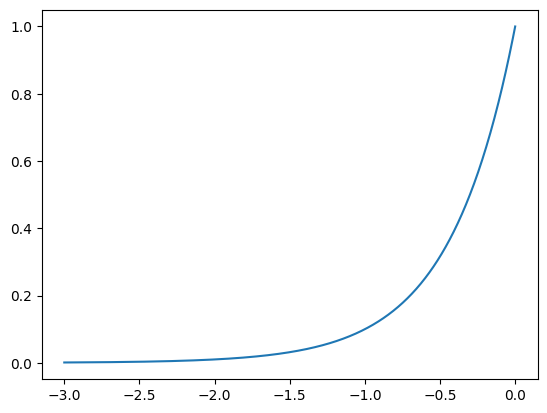

In [48]:
# determine good learning rate
# 1st determine range (0.001, 1)
# traverse the range exponentially, instead of linearly
#   low in the beginning, high in the end
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
plt.plot(lre, lrs)

In [49]:
lri = []
lossi = []
stepi = []

In [61]:
niter = 200000
lr1 = 0.1  # best learning rate determined experimentally
lr2 = 0.01  # learning rate decay (to be used after 'lr' has plateaued)
for i in range(niter):

  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32,))

  # forward pass
  emb = C[X_train[ix]]  # 32 x 3 x 2
  h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)  # 32 x 100
  logits = h @ W2 + b2  # 32 x 27
  loss = F.cross_entropy(logits, Y_train[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = lr1 if i < 100000 else lr2
  for p in parameters:
    # p.data += -lr * p.grad
    p.data += -lr2 * p.grad  # use learning rate decay, after lr has plateaued

  # track stats
  # lri.append(lre[i])  # learning rate
  stepi.append(i)
  lossi.append(loss.log10().item())  # loss
print(loss.item())

1.943627119064331


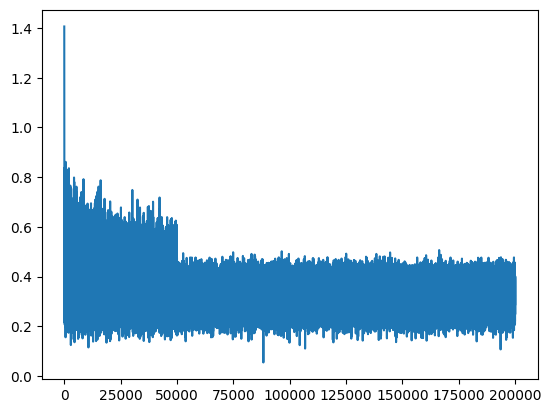

In [62]:
plt.plot(stepi, lossi)

In [63]:
# use train dataset (instead of minibatch) for inference & final loss computation
emb = C[X_train]
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.1295, grad_fn=<NllLossBackward0>)

In [64]:
# use Validation/Dev dataset (instead of minibatch) for inference & final loss computation
emb = C[X_dev]
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1570, grad_fn=<NllLossBackward0>)

In [73]:
# split data into
#   train set (80%)
#     optimize parameters of the model (weights) using gradient descent
#   dev/validation set (10%)
#     hyperparameter tuning
#       size of hidden layer 1
#       size of embedding, #neurons in 2nd layer
#       strength of regularization
#
#   test set (10%)

torch.Size([27, 10])


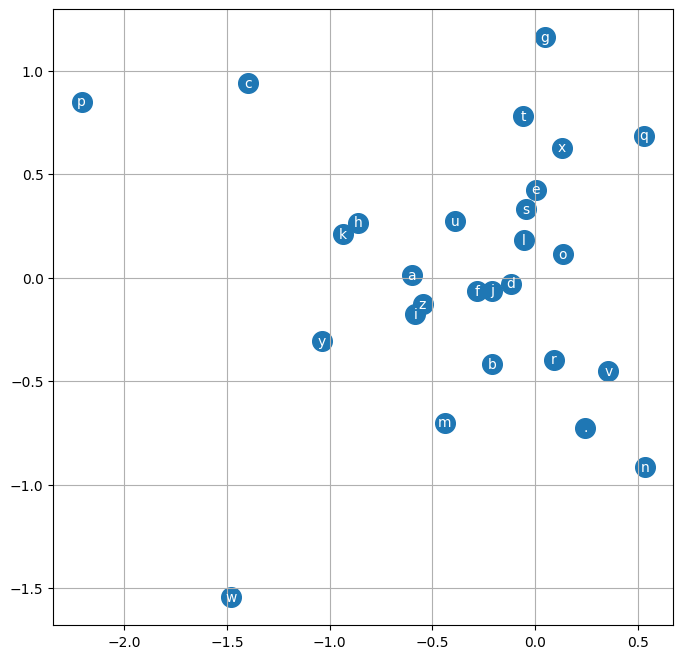

In [59]:
# Visualize embeddings
# vowels closeby, 'q', 'g', '.' isolated, rest clustered
print(C.shape)
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [66]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
  out = []
  context = [0] * block_sz  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # 1 x block_size x dimensions
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)  # exponent logits, then sum to 1
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()  # sample probabilities
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
niyah.
lorethan.
endraeg.
adeerdielin.
shi.
jenne.
elieananar.
kayziah.
karin.
shabergioghine.
kin.
reth.
konnie.
cayus.
kavda.
kylenizeks.
kayjahsi.
